In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,RocCurveDisplay,confusion_matrix,roc_auc_score

In [34]:
HepatitisC_all = pd.read_excel(f"C:\\Users\\김현종\\Desktop\\HCC Project\\DATA\\CHC_kks_0313.xlsx", index_col=False)
HepatitisC_all.fillna(-1, inplace=True)
HepatitisC_all.head()

,no,Site,ID,name,Age0,Gender,DM,Fatty_liver,cirrhosis,LSM_ini,...,Albumin48,LSM_FU48,APRI48,FIB448,AMAP48,MPAGEB48,HCC,HCC_time,Death,FU_time
0,2435.0,5,950313630,김기현,48.0,0,0.0,0.0,2.0,28.4,...,4.0,-1.0,1.666667,9.849371,59.531350,12.0,1,366.0,0,743.0
1,-1.0,10,1263102,오종섭,79.0,1,0.0,0.0,1.0,-1.0,...,4.0,-1.0,0.778146,5.242479,70.746189,14.0,1,370.0,0,1943.0
2,2173.0,5,140236064,박영미,75.0,1,0.0,0.0,1.0,-1.0,...,4.6,-1.0,0.440252,3.154556,54.780730,14.0,1,371.0,0,1953.0
3,-1.0,10,1671998,서숙경,82.0,1,0.0,0.0,1.0,-1.0,...,3.1,-1.0,1.772152,13.700567,77.444515,18.0,1,373.0,0,422.0
4,2102.0,5,50649314,이영임,80.0,1,1.0,0.0,1.0,-1.0,...,3.5,-1.0,0.228758,1.852941,59.618170,15.0,1,376.0,0,532.0


In [4]:
# RANDOM SEED 설정
seed = 26
np.random.seed(seed)

In [5]:
attr_all = HepatitisC_all.columns
print(attr_all)
HepatitisC_all = HepatitisC_all.iloc[np.random.permutation(len(HepatitisC_all))]

Index(['no', 'Site', 'ID', 'name', 'Age0', 'Gender', 'DM', 'Fatty_liver',
       'cirrhosis', 'LSM_ini', 'Platelet0', 'AST0', 'ALT0', 'Bilirubin0',
       'Albumin0', 'APRI0', 'FIB40', 'AMAP0', 'MPAGEB0', 'Age48', 'Platelet48',
       'AST48', 'ALT48', 'Bilirubin48', 'Albumin48', 'LSM_FU48', 'APRI48',
       'FIB448', 'AMAP48', 'MPAGEB48', 'HCC', 'HCC_time', 'Death', 'FU_time'],
      dtype='object')


In [6]:
attr_pool = ['HCC', 'Age0', 'Age48', 'Platelet0', 'Platelet48', 'AST0', 'AST48', 'ALT0', 'ALT48', 'Bilirubin0', 'Bilirubin48', 'Albumin0', 'Albumin48', 'APRI0', 'APRI48', 'FIB40', 'FIB448', 'AMAP0', 'AMAP48', 'MPAGEB0', 'MPAGEB48']  # Baseline + 1yr

attr = attr_pool

label = 'HCC'

HepatitisC = HepatitisC_all
for at in attr_all:
    
    if not at in attr_pool:
        HepatitisC = HepatitisC.drop(at,axis=1)           

In [7]:
HepatitisC = HepatitisC.astype(float)
print(HepatitisC)

      Age0  Platelet0   AST0   ALT0  Bilirubin0  Albumin0     APRI0     FIB40  \
912   54.0      362.0   35.0   23.0         0.5      3.50  0.241713  1.088653   
2364  60.0      182.0   48.0   57.0         0.8      4.20  0.659341  2.095963   
1381  78.0      168.0   53.0   34.0         0.5      3.90  0.788690  4.220090   
326   53.0      169.0   43.0   20.0         1.3      4.20  0.636095  3.015384   
1379  61.0      193.0   21.0   17.0         1.7      4.50  0.272021  1.609783   
...    ...        ...    ...    ...         ...       ...       ...       ...   
1985  47.0      174.0   69.0  109.0         1.0      4.87  0.991379  1.785190   
1456  44.0      199.0  203.0  479.0         1.1      4.36  2.550251  2.050822   
1798  60.0      174.0   95.0  165.0         0.5      4.20  1.364943  2.550255   
1342  32.0      253.0   44.0   64.0         1.7      4.50  0.434783  0.695652   
821   23.0      314.0   47.0   37.0         0.7      4.10  0.374204  0.565972   

         AMAP0  MPAGEB0  ..

In [8]:
columns = HepatitisC.columns
del_rows = []
for irow in range(len(HepatitisC)):
    
    missing_counts = 0
    for col in columns:
        if HepatitisC[col][irow] <0:
            missing_counts += 1
        
    if missing_counts>0:
        del_rows.append(irow)
        
del_rows = np.array(del_rows)        

HepatitisC = HepatitisC.drop(del_rows, axis = 0)

In [9]:
for at in attr_pool:
    
    if not at in attr:
        HepatitisC = HepatitisC.drop(at,axis=1)

In [10]:
HepatitisC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1984 entries, 2364 to 1456
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age0         1984 non-null   float64
 1   Platelet0    1984 non-null   float64
 2   AST0         1984 non-null   float64
 3   ALT0         1984 non-null   float64
 4   Bilirubin0   1984 non-null   float64
 5   Albumin0     1984 non-null   float64
 6   APRI0        1984 non-null   float64
 7   FIB40        1984 non-null   float64
 8   AMAP0        1984 non-null   float64
 9   MPAGEB0      1984 non-null   float64
 10  Age48        1984 non-null   float64
 11  Platelet48   1984 non-null   float64
 12  AST48        1984 non-null   float64
 13  ALT48        1984 non-null   float64
 14  Bilirubin48  1984 non-null   float64
 15  Albumin48    1984 non-null   float64
 16  APRI48       1984 non-null   float64
 17  FIB448       1984 non-null   float64
 18  AMAP48       1984 non-null   float64
 19  MPAGEB48

In [11]:
HepatitisC.HCC.value_counts()

HCC
0.0    1854
1.0     130
Name: count, dtype: int64

In [12]:
HepatitisC

,Age0,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,APRI0,FIB40,AMAP0,MPAGEB0,...,Platelet48,AST48,ALT48,Bilirubin48,Albumin48,APRI48,FIB448,AMAP48,MPAGEB48,HCC
2364,60.0,182.0,48.0,57.0,0.8,4.20,0.659341,2.095963,47.62354,12.0,...,188.0,24.0,15.0,0.9,4.40,0.319149,2.010655,47.17948,12.0,0.0
1381,78.0,168.0,53.0,34.0,0.5,3.90,0.788690,4.220090,56.27637,15.0,...,178.0,26.0,20.0,0.6,4.40,0.365169,2.580272,54.79095,14.0,0.0
326,53.0,169.0,43.0,20.0,1.3,4.20,0.636095,3.015384,46.11235,10.0,...,167.0,29.0,32.0,0.5,4.90,0.434132,1.657678,43.82572,10.0,0.0
1379,61.0,193.0,21.0,17.0,1.7,4.50,0.272021,1.609783,47.15652,12.0,...,230.0,17.0,14.0,1.4,4.60,0.184783,1.224754,44.59990,11.0,0.0
183,67.0,225.0,50.0,109.0,0.6,3.80,0.555556,1.426097,48.39540,12.0,...,176.0,20.0,15.0,1.0,4.60,0.284091,1.995173,50.37992,12.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208,45.0,305.0,27.0,15.0,1.2,4.10,0.221311,1.028563,33.85700,5.0,...,309.0,22.0,13.0,0.8,4.00,0.177994,0.908344,33.89160,5.0,0.0
2010,54.0,195.0,69.0,50.0,0.9,4.70,0.884615,2.702236,43.03129,10.0,...,224.0,27.0,27.0,0.8,4.90,0.301339,1.275841,40.81059,9.0,0.0
1126,49.0,95.0,89.0,32.0,7.4,3.30,2.342105,8.114981,59.63529,14.0,...,164.0,64.0,26.0,2.8,2.60,0.975610,3.826656,56.40278,15.0,0.0
1985,47.0,174.0,69.0,109.0,1.0,4.87,0.991379,1.785190,47.26266,10.0,...,224.0,13.0,16.0,0.6,4.33,0.145089,0.696429,45.30299,9.0,0.0


## Data split

In [13]:
X = HepatitisC.drop('HCC',axis=1)
y = HepatitisC['HCC']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=seed)

In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=seed)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print('SMOTE 적용 후: ', y_train_over.value_counts())

SMOTE 적용 후:  HCC
1.0    1299
0.0    1299
Name: count, dtype: int64


In [15]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

smote_tomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_train_Sm_To, y_train_Sm_To = smote_tomek.fit_resample(X_train, y_train)

print('SMOTE-Tomek 적용 후: ', y_train_Sm_To.value_counts())

SMOTE-Tomek 적용 후:  HCC
1.0    1299
0.0    1291
Name: count, dtype: int64


In [16]:
X_train

,Age0,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,APRI0,FIB40,AMAP0,MPAGEB0,Age48,Platelet48,AST48,ALT48,Bilirubin48,Albumin48,APRI48,FIB448,AMAP48,MPAGEB48
27,71.0,110.0,62.0,71.0,0.6,3.70,1.409091,4.749284,64.10898,18.0,72.0,188.0,11.0,6.0,0.4,4.10,0.146277,1.719855,57.74899,16.0
638,63.0,113.0,24.0,19.0,1.0,3.70,0.530973,3.069704,61.13187,16.0,64.0,153.0,28.0,19.0,0.9,4.40,0.457516,2.687013,56.79357,14.0
2743,63.0,277.0,24.0,27.0,0.9,4.49,0.216606,1.050486,47.74274,11.0,64.0,236.0,20.0,10.0,0.7,4.38,0.211864,1.715134,50.99533,13.0
1300,75.0,187.0,20.0,15.0,0.9,4.10,0.267380,2.071114,53.76505,14.0,76.0,200.0,23.0,14.0,0.9,4.30,0.287500,2.335863,52.73734,13.0
1517,62.0,204.0,49.0,91.0,0.3,4.50,0.600490,1.561122,45.20218,11.0,63.0,215.0,16.0,16.0,0.4,4.30,0.186047,1.172093,45.68541,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444,60.0,192.0,42.0,41.0,0.4,4.10,0.546875,2.049781,52.60343,14.0,61.0,230.0,25.0,32.0,0.6,5.00,0.271739,1.172106,48.32260,13.0
1537,57.0,216.0,31.0,32.0,0.6,4.76,0.358796,1.446132,48.31008,11.0,58.0,217.0,34.0,27.0,0.8,4.99,0.391705,1.748901,48.27975,11.0
9,47.0,132.0,151.0,291.0,0.9,3.80,2.859848,3.151769,52.97079,12.0,48.0,137.0,35.0,49.0,1.2,4.00,0.638686,1.751825,52.75270,11.0
2355,58.0,233.0,15.0,19.0,0.7,4.30,0.160944,0.856617,42.95685,9.0,59.0,271.0,12.0,14.0,0.9,4.50,0.110701,0.698232,40.47064,7.0


In [17]:
X_train_over

,Age0,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,APRI0,FIB40,AMAP0,MPAGEB0,Age48,Platelet48,AST48,ALT48,Bilirubin48,Albumin48,APRI48,FIB448,AMAP48,MPAGEB48
0,71.000000,110.000000,62.000000,71.000000,0.600000,3.700000,1.409091,4.749284,64.108980,18.000000,72.000000,188.000000,11.000000,6.000000,0.400000,4.100000,0.146277,1.719855,57.748990,16.000000
1,63.000000,113.000000,24.000000,19.000000,1.000000,3.700000,0.530973,3.069704,61.131870,16.000000,64.000000,153.000000,28.000000,19.000000,0.900000,4.400000,0.457516,2.687013,56.793570,14.000000
2,63.000000,277.000000,24.000000,27.000000,0.900000,4.490000,0.216606,1.050486,47.742740,11.000000,64.000000,236.000000,20.000000,10.000000,0.700000,4.380000,0.211864,1.715134,50.995330,13.000000
3,75.000000,187.000000,20.000000,15.000000,0.900000,4.100000,0.267380,2.071114,53.765050,14.000000,76.000000,200.000000,23.000000,14.000000,0.900000,4.300000,0.287500,2.335863,52.737340,13.000000
4,62.000000,204.000000,49.000000,91.000000,0.300000,4.500000,0.600490,1.561122,45.202180,11.000000,63.000000,215.000000,16.000000,16.000000,0.400000,4.300000,0.186047,1.172093,45.685410,11.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593,62.053532,129.369021,63.871872,17.657745,0.928872,4.097323,1.231495,7.348447,52.408807,13.342255,63.053532,143.946468,36.497149,13.604213,0.931549,4.365774,0.630979,4.264568,51.118093,13.000000
2594,73.729308,57.108277,34.310515,19.310515,1.567517,3.632483,1.509217,10.159594,66.632882,16.837585,74.729308,62.541385,29.418792,20.472931,1.414810,4.048438,1.217277,8.130249,65.389486,17.891723
2595,67.248836,295.872103,45.037208,49.883720,0.639419,4.021163,0.443098,1.766987,49.168051,11.759302,68.248836,254.311633,21.817442,27.298838,0.660581,4.278837,0.218590,1.278656,51.705049,11.365116
2596,59.472513,123.260035,21.493310,14.369982,0.971917,3.900000,0.453685,2.724249,56.730700,14.876673,60.472513,139.595841,26.369982,20.178301,0.800000,4.156166,0.473960,2.625677,55.141336,13.876673


In [18]:
X_train_Sm_To

,Age0,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,APRI0,FIB40,AMAP0,MPAGEB0,Age48,Platelet48,AST48,ALT48,Bilirubin48,Albumin48,APRI48,FIB448,AMAP48,MPAGEB48
0,71.000000,110.000000,62.000000,71.000000,0.600000,3.700000,1.409091,4.749284,64.108980,18.000000,72.000000,188.000000,11.000000,6.000000,0.400000,4.100000,0.146277,1.719855,57.748990,16.000000
1,63.000000,113.000000,24.000000,19.000000,1.000000,3.700000,0.530973,3.069704,61.131870,16.000000,64.000000,153.000000,28.000000,19.000000,0.900000,4.400000,0.457516,2.687013,56.793570,14.000000
2,63.000000,277.000000,24.000000,27.000000,0.900000,4.490000,0.216606,1.050486,47.742740,11.000000,64.000000,236.000000,20.000000,10.000000,0.700000,4.380000,0.211864,1.715134,50.995330,13.000000
3,75.000000,187.000000,20.000000,15.000000,0.900000,4.100000,0.267380,2.071114,53.765050,14.000000,76.000000,200.000000,23.000000,14.000000,0.900000,4.300000,0.287500,2.335863,52.737340,13.000000
4,62.000000,204.000000,49.000000,91.000000,0.300000,4.500000,0.600490,1.561122,45.202180,11.000000,63.000000,215.000000,16.000000,16.000000,0.400000,4.300000,0.186047,1.172093,45.685410,11.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,60.466652,45.901746,44.336840,24.978962,0.600000,3.432632,2.439066,12.489581,58.884360,15.228066,61.466652,55.684199,26.684199,17.792972,0.455439,4.178245,1.174938,6.971244,56.301318,13.782453
2586,59.746591,108.248864,27.152954,18.052500,0.855023,3.765068,0.630843,3.483861,53.778535,12.899545,60.746591,134.650682,30.952045,26.554772,0.889955,4.255023,0.573820,2.840880,51.073739,11.899545
2587,49.739255,39.369807,135.238718,61.652221,1.823908,3.198917,9.084216,22.570673,62.668888,14.326110,50.739255,47.065365,29.130372,11.652221,1.389130,4.010870,1.578912,9.367791,60.060449,12.434814
2588,64.344593,135.568409,20.516890,11.293074,0.970693,4.046537,0.373713,2.880771,59.161821,16.293074,65.344593,137.483110,24.172297,12.241555,0.829307,4.158615,0.441638,3.481400,58.981150,15.586148


In [19]:
y_train

27      1.0
638     0.0
2743    0.0
1300    0.0
1517    0.0
       ... 
2444    0.0
1537    0.0
9       1.0
2355    0.0
2162    0.0
Name: HCC, Length: 1388, dtype: float64

In [23]:
train_HCC = []
train_label = y_train.to_list()
for idx in range(len(train_label)):
    if train_label[idx] == 1.0:
        train_HCC.append(idx)

In [33]:
attr_df_HCC = X_train.loc[train_HCC]
attr_df_HCC

KeyError: '[42, 59, 91, 95, 131, 137, 164, 175, 195, 204, 208, 219, 292, 299, 305, 313, 359, 367, 368, 402, 416, 435, 437, 462, 511, 544, 579, 601, 617, 650, 668, 717, 843, 867, 937, 943, 956, 967, 1036, 1063, 1077, 1095, 1122, 1128, 1132, 1161, 1179, 1192, 1200, 1212, 1237, 1261, 1268, 1309, 1335, 1338, 1363, 1385] not in index'

### Save test sets and results to CSV

In [19]:
### Due to random samples, indices are shuffled-> reorganize sample orders and run the prediction -> save to csv
attr_x = X_test.columns
row_num = y_test.index  # 환자 번호 (CSV 파일에서 no.)
Xt = np.moveaxis(np.array(X_test.values.tolist()),0,-1)  # X_test.values.tolist() --> 645명의 환자에 대한 8 attributes에 따른 data를 list로 저장
# Xt.shape: (8, 645)
for ii in range(Xt.shape[0]):
    if ii == 0:
        x_test_re = pd.DataFrame({str(attr_x[ii]):Xt[ii]})
    else:
        tmp = pd.DataFrame({str(attr_x[ii]):Xt[ii]})
        x_test_re = x_test_re.join(tmp)
# x_test_re: 재배열된 X_test

# [HCC, name, ID] DataFrame을 생성한다
gt =  pd.DataFrame({'HCC':np.array(y_test.values.tolist())})
name = pd.DataFrame({'Name':np.array(HepatitisC_all['name'][row_num].values.tolist())})
ID = pd.DataFrame({'ID':np.array(HepatitisC_all['ID'][row_num].values.tolist())})

## 3. Random Forest

In [20]:
forest_clf = RandomForestClassifier()
parameters = {'max_depth':[3,5,7,9], 'min_samples_leaf':[5,10,15,20]}

f_clf_GS = GridSearchCV(forest_clf, parameters, cv=3)
f_clf_GS.fit(X_train_Sm_To, y_train_Sm_To)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [5, 10, 15, 20]})

In [21]:
print('Train AUC-ROC score is', roc_auc_score(y_train_Sm_To, f_clf_GS.predict_proba(X_train_Sm_To)[:, 1]))
print('Test AUC-ROC score is', roc_auc_score(y_test, f_clf_GS.predict_proba(X_test)[:, 1]))

Train AUC-ROC score is 0.994779395936456
Test AUC-ROC score is 0.8620522961986377


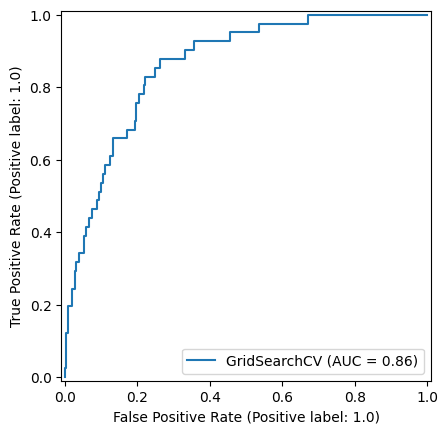

In [22]:
RocCurveDisplay.from_estimator(f_clf_GS,X_test,y_test)
y_test_pred_RF = f_clf_GS.predict_proba(x_test_re)[:, 1]

pred = pd.DataFrame({'Predition':np.array(y_test_pred_RF)})
# results = ID.join(name)
# results = results.join(x_test_re)
# results = results.join(gt)
# results = results.join(pred)

# 결과를 CSV/EXCEL 파일로 저장
# results.to_csv('Results_Random_Forest.csv', index=False)
# results.to_excel('Results_Random_Forest.xlsx', index=False)

In [23]:
# thresholds = np.linspace(0.06,0.09,10)
# print(thresholds)
# for th in thresholds:
#     y_pred = np.zeros((y_test_pred_RF.shape),dtype = float)
#     y_pred[y_test_pred_RF>th] = 1
#     TP = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==1)]
#     FP = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==1)]
#     TN = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==0)]
#     FN = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==0)]
#     print("Confusion matrix: threshold - %.3f"%th)
#     print("T    |      Prediction      | ")
#     print("R    |     N     |    P     | ")
#     print("U  0 |    %.3f   |   %.3f   | "%(float(len(TN))/float(len(FP)+len(TN)),float(len(FP))/float(len(FP)+len(TN))))
#     print("E  1 |    %.3f   |   %.3f   | "%(float(len(FN))/float(len(TP)+len(FN)),float(len(TP))/float(len(TP)+len(FN))))
    
#     # print(confusion_matrix(y_test,y_pred,normalize='true'))

## AUROC with 95% confidence interval

In [24]:
import sklearn.metrics
import numpy as np
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import pandas as pd

import calc_froc

In [25]:
from calc_froc import plot_roc_with_ci,plot_roc_with_ci

In [26]:
from typing import List, Tuple, Union, Any

In [27]:
def roc_with_ci(
    preds: np.array,
    labels: np.array,
    ci: float = 95,
    nbst: int = 1000,
    seed: Union[int, np.random.Generator] = None,
) -> dict:
    fprs, tprs, ths = sklearn.metrics.roc_curve(labels, preds)
    auc = sklearn.metrics.auc(fprs, tprs)

    # bootstrap to get confidence interval
    tpr_bst_list = []
    auc_bst_list = []
    rng = np.random.default_rng(seed)
    for i in range(nbst):
        # sampling with replacement
        ind = rng.integers(0, len(labels), len(labels))
        label_bst = labels[ind]
        pred_bst = preds[ind]

        # calculate ROC for each bootstrap
        fpr_bst, tpr_bst, _ = sklearn.metrics.roc_curve(label_bst, pred_bst)

        # resample the roc for each fprs
        tpr_sample = np.interp(fprs, fpr_bst, tpr_bst)
        tpr_bst_list.append(tpr_sample)
        auc_bst_list.append(sklearn.metrics.auc(fpr_bst, tpr_bst))

    tpr_bst_list = np.array(tpr_bst_list)
    tprs_ci = np.percentile(tpr_bst_list, [(100 - ci) / 2, 100 - (100 - ci) / 2], axis=0)
    auc_ci = np.percentile(auc_bst_list, [(100 - ci) / 2, 100 - (100 - ci) / 2])

    return {
        'fprs': fprs,
        'tprs': tprs,
        'ths': ths,
        'tprs_ci': tprs_ci,
        'auc': auc,
        'auc_ci': auc_ci
    }

def roc_with_ci_draw(pred,gt,save_fig_name):
    results = roc_with_ci(np.array(pred),np.array(gt))

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    linestyle_cycle = ['-', '--']
    fig, ax = plt.subplots(figsize=[6, 4], dpi=300)
    
    color = colors[0]
    linestyle = linestyle_cycle[0]
    
    ax = plot_roc_with_ci(
        ax, results['fprs'], results['tprs'], results['tprs_ci'], color=color, linestyle=linestyle
    )
    
    ax.set_xlabel('False positive')
    ax.set_ylabel('True positive')
    ax.grid(True)
    ax.set_xlim([-0.03, 1])
    ax.set_ylim([-0.03, 1.03])
    ax.legend(['AUC = %.2f $\pm$ 95 %% confidence'%results['auc']],loc=4)
    # plt.savefig(save_fig_name)  # FROC plot 저장
    plt.show()

<>:61: SyntaxWarning: invalid escape sequence '\p'
<>:61: SyntaxWarning: invalid escape sequence '\p'
C:\Users\김현종\AppData\Local\Temp\ipykernel_17268\1492191649.py:61: SyntaxWarning: invalid escape sequence '\p'
  ax.legend(['AUC = %.2f $\pm$ 95 %% confidence'%results['auc']],loc=4)


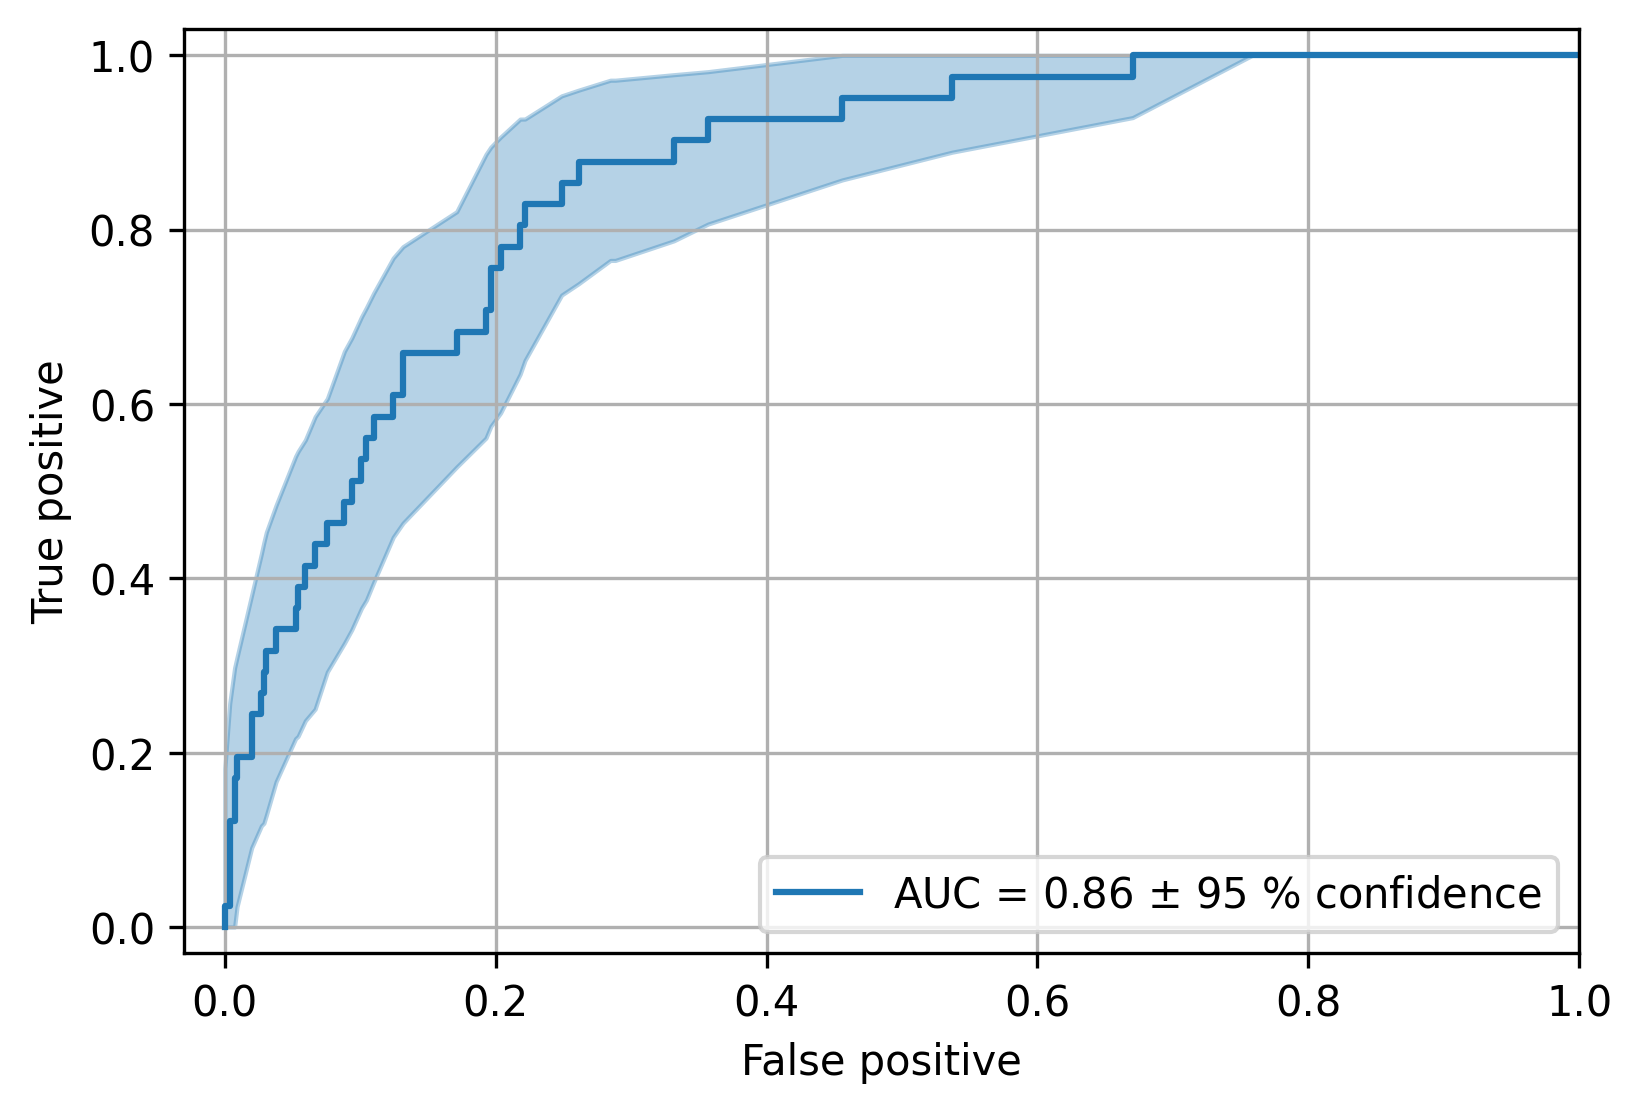

In [28]:
roc_with_ci_draw(y_test_pred_RF,gt,'RandomForest')